# Bayesian eruption age estimation example notebook

### Load external resources

In [62]:
# Required packages
using Plots; gr();
using KernelDensity: kde

# Functions we'll be using here
include("DistTools.jl");

## Test bayesian eruption age estimation with a synthetic dataset

#### Generate synthetic zircon age dataset

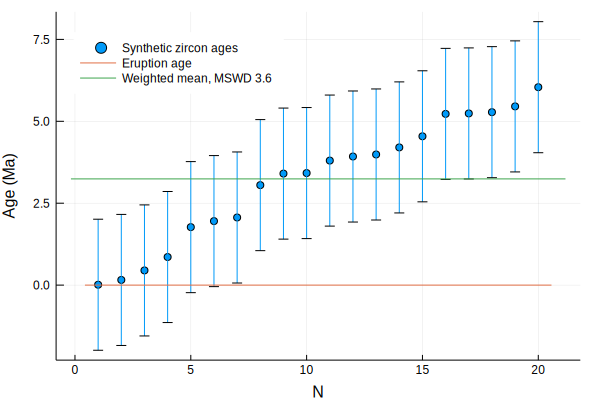

In [122]:
dt_sigma = 5; # Timescale relative to analytical uncertainty
N = 20; # Number of zircons
 
# Draw set of pseudorandom ages from MELTS volcanic zircon distribution, 
# with true minimum == 0 and analytical sigma == 1
ages = draw_from_distribution(MeltsVolcanicZirconDistribution,N).*dt_sigma + randn(N);
uncert = ones(N)

# Calculate the weighted mean age
(wx, wsigma, mswd) = awmean(ages, uncert)

h = plot(1:length(ages),sort(ages),yerror=uncert*2,seriestype=:scatter, label="Synthetic zircon ages", ylabel="Age (Ma)", xlabel="N")
plot!(h,collect(xlims()), [0,0], label="Eruption age",fg_color_legend=:white, legend=:topleft)
plot!(h,collect(xlims()), [wx,wx], label="Weighted mean, MSWD $(signif(mswd,2))")

#### Calculate bootstrapped distribtution

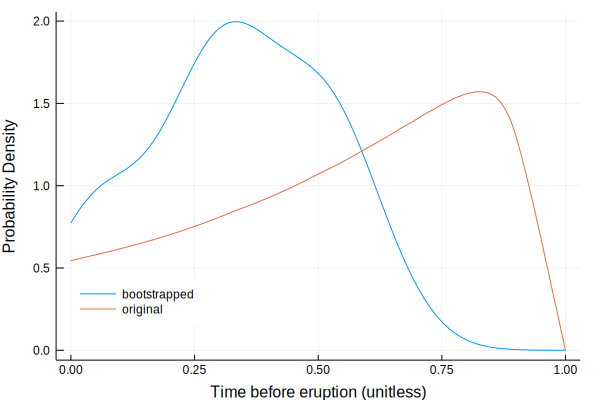

In [134]:
# Maximum extent of expected analytical tail (beyond eruption/deposition)
maxTailLength = mean(uncert) * norm_quantile(1-1/(length(ages) + 1));
included = (ages-minimum(ages)) .>= maxTailLength;

# Bootstrapped crystallization distribution, excluding maximum analytical tail
if sum(included) > 5
    dist = BootstrapCrystDistributionKDE(ages[included]);
else
    # Avoid edge cases at n = 0 and n = 2;
    # Default to n = 1 instead, which yields a half-normal distribution
    dist = BootstrapCrystDistributionKDE([0.]);
end
dist = dist./mean(dist);

# Plot bootstrapped distribution
plot(linspace(0,1,length(dist)),dist, label="bootstrapped", ylabel="Probability Density", xlabel="Time before eruption (unitless)", legend=:bottomleft, fg_color_legend=:white)
plot!(linspace(0,1,100),MeltsVolcanicZirconDistribution,label="original")

#### Run MCMC to estimate eruption/deposition age distribution of synthetic dataset

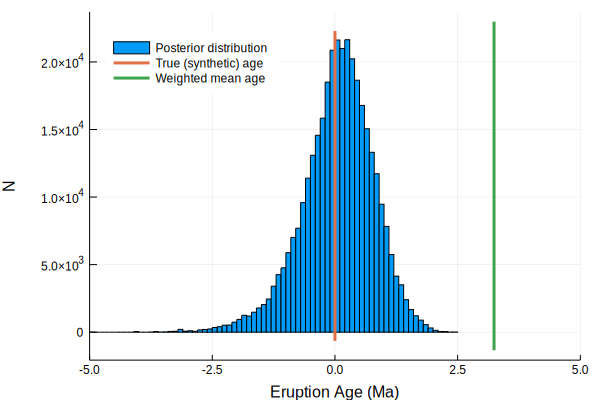


Estimated eruption age of synthetic dataset:
 0.05583596091283498 +/- 0.7343666434599349 Ma
 (True synthetic age 0 Ma)

In [125]:
# Configure model
nsteps = 500000; # Length of Markov chain
burnin = 150000; # Number of steps to discard at beginning of Markov chain

# Run MCMC
tminDist = Array{Float64,1}(nsteps);
metropolis_min(nsteps,dist,ages,uncert,tminDist);

# Plot results
h = histogram(tminDist[burnin:end],nbins=100,xlims=(-5,5),label="Posterior distribution",xlabel="Eruption Age (Ma)",ylabel="N")
plot!(h,[0,0],collect(ylims()),line=(3),label="True (synthetic) age",fg_color_legend=:white)
plot!(h,[wx,wx],collect(ylims()),line=(3),label="Weighted mean age",legend=:topleft)
display(h)

# Print results
AgeEst = mean(tminDist[burnin:end]);
AgeEst_sigma = std(tminDist[burnin:end]);
print("\nEstimated eruption age of synthetic dataset:\n $AgeEst +/- $AgeEst_sigma Ma\n (True synthetic age 0 Ma)")

## Now let's try with some real zircon data from the Fish Canyon Tuff

In [136]:
# Read in data and two-sigma uncertainty from file
wotzlaw = readcsv("../examples/literature dataset tests/WotzlawFCTMLX.csv")

43×2 Array{Float64,2}:
 28.289  0.058
 28.4    0.028
 28.196  0.038
 28.215  0.038
 28.383  0.035
 28.332  0.063
 28.452  0.025
 28.379  0.051
 28.638  0.025
 28.561  0.026
 28.52   0.028
 28.206  0.031
 28.454  0.02 
  ⋮           
 28.655  0.043
 28.584  0.024
 28.475  0.022
 28.565  0.03 
 28.422  0.039
 28.359  0.049
 28.485  0.037
 28.454  0.028
 28.611  0.043
 28.428  0.035
 28.241  0.046
 28.232  0.036

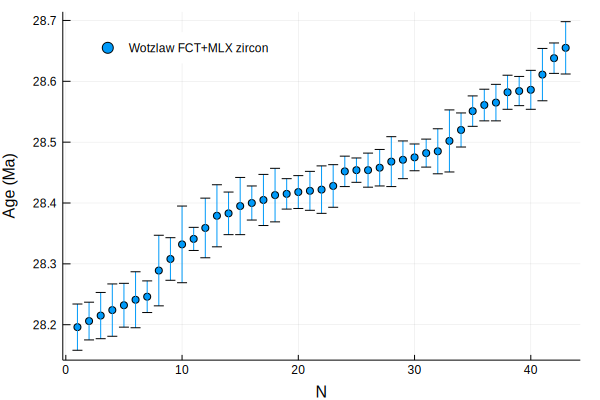

In [148]:
# Rank-order plot of imported Wotzlaw ages
t = sortperm(wotzlaw[:,1]);
ages = wotzlaw[t,1];
uncert = wotzlaw[t,2]/2;
h = plot(1:length(ages),ages,yerror=uncert*2,seriestype=:scatter, label="Wotzlaw FCT+MLX zircon", ylabel="Age (Ma)", xlabel="N", legend=:topleft, fg_color_legend=:white)

#### Calculate bootstrapped distribtution

In [141]:
# Maximum extent of expected analytical tail (beyond eruption/deposition)
maxTailLength = mean(uncert) * norm_quantile(1-1/(length(ages) + 1));
included = (ages-minimum(ages)) .>= maxTailLength;

# Bootstrapped crystallization distribution, excluding maximum analytical tail
if sum(included) > 5
    dist = BootstrapCrystDistributionKDE(ages[included]);
else
    # Avoid edge cases at n = 0 and n = 2;
    # Default to n = 1 instead, which yields a half-normal distribution
    dist = BootstrapCrystDistributionKDE([0.]);
end
dist = dist./mean(dist);

# # Plot bootstrapped distribution
# plot(linspace(0,1,length(dist)),dist, label="bootstrapped", ylabel="Probability Density", xlabel="Time before eruption (unitless)", legend=:bottomleft, fg_color_legend=:white)

#### Run MCMC to estimate eruption age of Wotzlaw FCT dataset

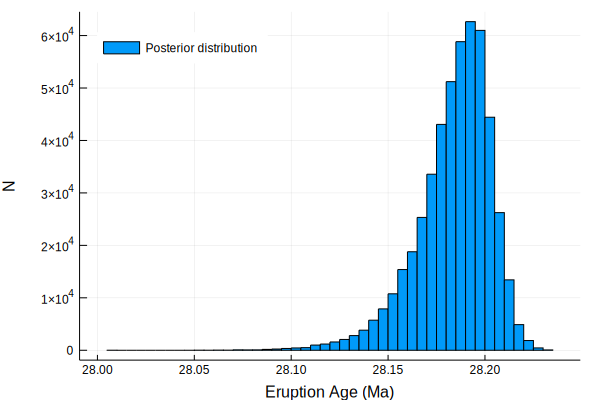

In [173]:
# Configure model
nsteps = 1000000; # Length of Markov chain
burnin = 500000; # Number of steps to discard at beginning of Markov chain

# Run MCMC
tminDist = Array{Float64,1}(nsteps);
metropolis_min(nsteps,dist,ages,uncert,tminDist);

# Plot results
h = histogram(tminDist[burnin:end],nbins=100,label="Posterior distribution",xlabel="Eruption Age (Ma)",ylabel="N",legend=:topleft,fg_color_legend=:white)
# plot!(h,[wx,wx],collect(ylims()),line=(3),label="Weighted mean age",legend=:topleft)
display(h)

# Print results
AgeEst = mean(tminDist[burnin:end]);
AgeEst_sigma = std(tminDist[burnin:end]);
print("\nEstimated eruption age:\n $AgeEst +/- $AgeEst_sigma Ma\n")

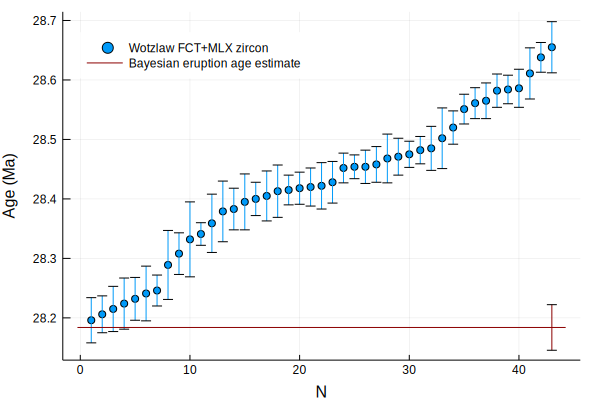

In [175]:
# Plot eruption age estimate relative to rank-order plot of raw zircon ages
h = plot(1:length(ages),ages,yerror=uncert*2,seriestype=:scatter, label="Wotzlaw FCT+MLX zircon", ylabel="Age (Ma)", xlabel="N", legend=:topleft, fg_color_legend=:white)
plot!(h,[length(ages)],[AgeEst],yerror=2*AgeEst_sigma,label="Bayesian eruption age estimate",color=:darkred)
plot!(h,collect(xlims()),[AgeEst,AgeEst],color=:darkred,label="")